# **EXPLICABILIDAD DE MODELOS PREDICTIVOS CON RANDOM FOREST**
# **Análisis con SHAP y LIME sobre el dataset Social Network Ads**

# **Objetivo**
Entrenar un modelo supervisado de clasificación basado en Random Forest para predecir la variable *Purchased*, y aplicar técnicas de explicabilidad (SHAP y LIME) con el fin de comprender cómo las variables influyen en las decisiones del modelo, así como reflexionar sobre la transparencia, los riesgos éticos y las implicaciones sociales de su posible implementación.

In [25]:
# ============================================
# 1: Carga del dataset y revisión inicial
# ============================================

# ===============================
# Instalación de librerías
# ===============================
!pip -q install lime
!pip -q install shap

# ===============================
# Importación de librerías
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer


# Configuración de visualizaciones
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Lectura del dataset
df = pd.read_csv("Social_Network_Ads_1.csv")

# Visualización inicial del conjunto de datos
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [3]:
# ============================================
# 2: Inspección estructural del dataset
# ============================================

# Información general del dataset
df.info()

# Estadísticos descriptivos de las variables numéricas
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


Distribución de Purchased (conteos):
Purchased
0    257
1    143
Name: count, dtype: int64

Distribución de Purchased (proporciones):
Purchased
0    0.6425
1    0.3575
Name: proportion, dtype: float64


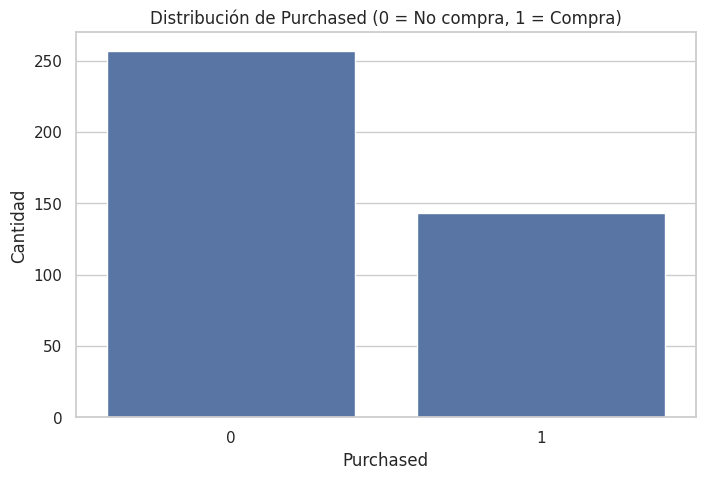

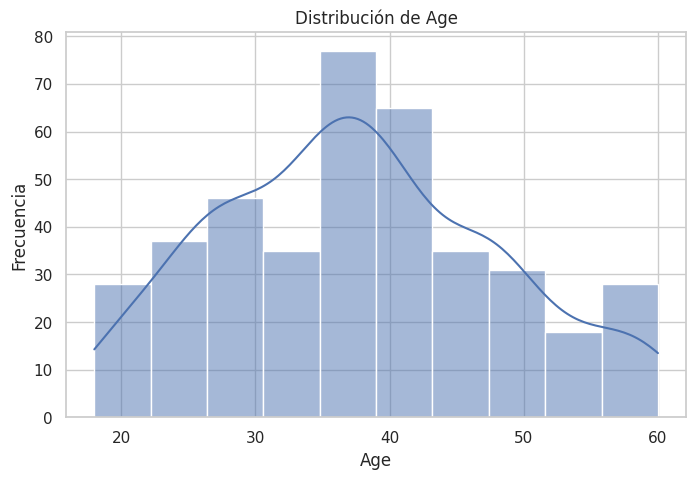

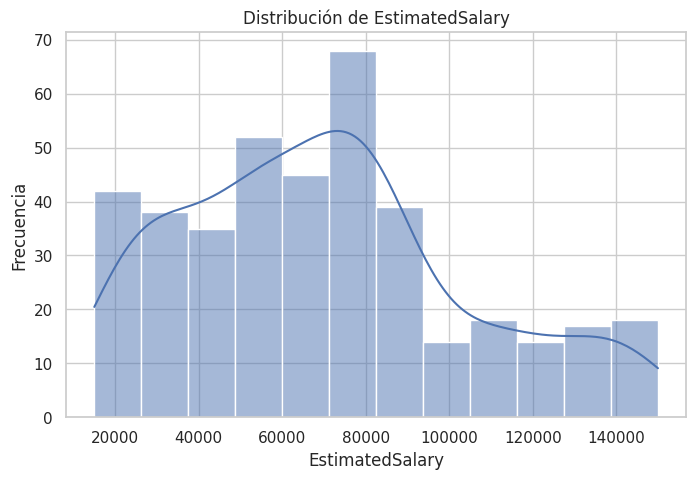

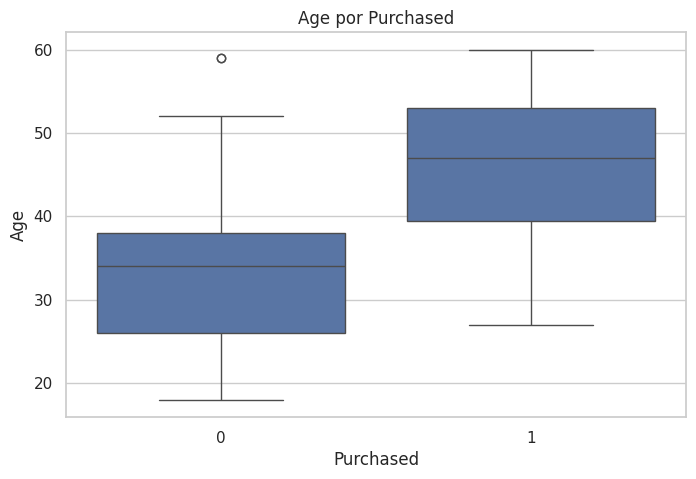

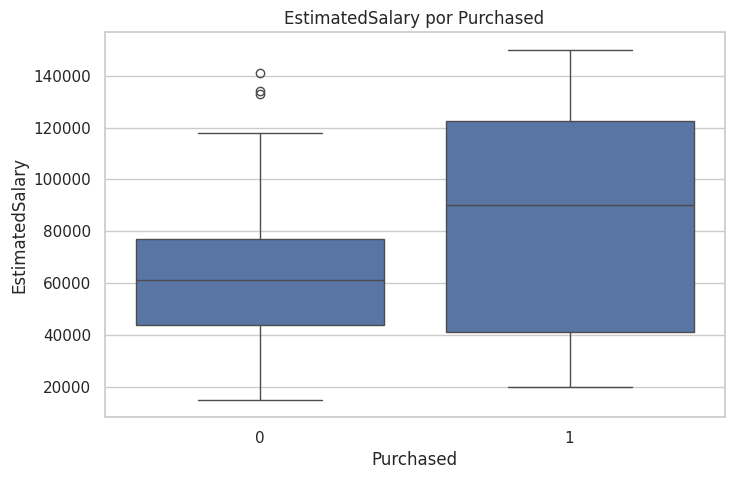

In [4]:
# ============================================
# 3: EDA general (distribución y resumen)
# ============================================

# 1) Distribución de la variable objetivo (Purchased)
target_counts = df["Purchased"].value_counts()
target_props = df["Purchased"].value_counts(normalize=True)

print("Distribución de Purchased (conteos):")
print(target_counts)
print("\nDistribución de Purchased (proporciones):")
print(target_props)

# Gráfico de conteos de la variable objetivo
plt.figure()
sns.countplot(x="Purchased", data=df)
plt.title("Distribución de Purchased (0 = No compra, 1 = Compra)")
plt.xlabel("Purchased")
plt.ylabel("Cantidad")
plt.show()

# 2) Distribución de variables numéricas
num_cols = ["Age", "EstimatedSalary"]

for col in num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

# 3) Boxplots por clase para evaluar separabilidad inicial
for col in num_cols:
    plt.figure()
    sns.boxplot(x="Purchased", y=col, data=df)
    plt.title(f"{col} por Purchased")
    plt.xlabel("Purchased")
    plt.ylabel(col)
    plt.show()

### Análisis exploratorio general del conjunto de datos

La variable objetivo *Purchased* presenta una distribución moderadamente desbalanceada. Se registran 257 observaciones correspondientes a la clase 0 (no compra), lo que representa aproximadamente el 64,25 % del total, mientras que la clase 1 (compra) cuenta con 143 observaciones, equivalentes al 35,75 %. Aunque no se trata de un desbalance extremo, esta diferencia debe considerarse en la evaluación del desempeño del modelo.

La variable *Age* muestra una distribución continua con valores que abarcan aproximadamente desde los 18 hasta los 60 años. El histograma sugiere una mayor concentración de observaciones en el rango de edades intermedias, con una dispersión razonable hacia valores más altos. Al analizar *Age* en función de la variable *Purchased*, el diagrama de caja evidencia una clara diferencia entre las clases: los usuarios que realizan una compra tienden a presentar edades mayores, con una mediana superior en comparación con quienes no compran.

En el caso de *EstimatedSalary*, la distribución se extiende desde valores cercanos a 15 000 hasta aproximadamente 150 000. El histograma indica una mayor densidad de observaciones en los rangos salariales medios, con una cola hacia salarios más altos. El boxplot por clase revela que los usuarios que realizan una compra presentan, en general, salarios estimados más elevados y una mayor variabilidad en comparación con aquellos que no compran.

En conjunto, los gráficos sugieren que tanto la edad como el ingreso estimado muestran una relación diferenciadora con respecto a la decisión de compra, lo que indica que estas variables podrían tener un peso relevante en el proceso de clasificación del modelo predictivo.

In [5]:
# ============================================
# 4: Preprocesamiento de los datos
# ============================================

# Copia del dataset para evitar modificar el original
df_prep = df.copy()

# Eliminación de la columna User ID (identificador)
df_prep = df_prep.drop(columns=["User ID"])

# Codificación binaria de Gender
# Female = 0, Male = 1
df_prep["Gender"] = df_prep["Gender"].map({"Female": 0, "Male": 1})

# Separación de variables predictoras (X) y variable objetivo (y)
X = df_prep.drop(columns=["Purchased"])
y = df_prep["Purchased"]

# División en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Verificación de dimensiones
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((300, 3), (100, 3), (300,), (100,))

### Análisis del preprocesamiento de los datos

Tras la eliminación de la variable *User ID* y la codificación binaria de la variable *Gender*, el conjunto de datos quedó conformado por tres variables predictoras: género, edad e ingreso estimado. Esta selección mantiene un equilibrio entre simplicidad del modelo y capacidad explicativa, permitiendo además analizar implicaciones éticas asociadas al uso de variables sensibles.

La división del conjunto de datos se realizó utilizando una proporción de 75 % para entrenamiento y 25 % para prueba, lo que resultó en 300 observaciones para el entrenamiento y 100 para la evaluación del modelo. La estratificación aplicada sobre la variable objetivo *Purchased* garantiza que la distribución de clases se mantenga consistente en ambos subconjuntos, reduciendo el riesgo de sesgos en la evaluación del desempeño.

El número de variables predictoras es reducido, lo que favorece la interpretabilidad del modelo y facilita la aplicación posterior de técnicas de explicabilidad como SHAP y LIME, tanto a nivel global como local.

### Justificación metodológica: no escalado de variables

En este estudio no se aplicó escalado a las variables numéricas (*Age* y *EstimatedSalary*). Esta decisión se fundamenta en que el modelo seleccionado, Random Forest, es un algoritmo basado en árboles de decisión y, por tanto, no depende de la distancia entre observaciones ni de la magnitud relativa de las variables para realizar particiones.

Adicionalmente, mantener las variables en su escala original favorece la interpretabilidad de los resultados, especialmente en la aplicación de técnicas de explicabilidad como SHAP y LIME, ya que las contribuciones de las variables pueden analizarse directamente en unidades comprensibles desde el dominio del problema.

Por estas razones, el no escalado de las variables resulta coherente tanto desde el punto de vista técnico como desde el enfoque de explicabilidad y análisis ético del modelo.

In [8]:
# ============================================
# 5: Entrenamiento del modelo Random Forest
# ============================================

# Definición del modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,        # Número de árboles
    max_depth=None,          # Profundidad máxima (None = crecimiento completo)
    random_state=42,
    class_weight="balanced"  # Considera el ligero desbalance de clases
)

# Entrenamiento del modelo
rf_model.fit(X_train, y_train)

# Verificación rápida: número de árboles entrenados
len(rf_model.estimators_)

100

### Análisis del entrenamiento del modelo Random Forest

El modelo Random Forest fue entrenado correctamente utilizando el conjunto de datos de entrenamiento, confirmándose la construcción de 100 árboles de decisión, de acuerdo con el valor establecido en el hiperparámetro *n_estimators*.

La utilización de un número moderado de árboles permite capturar relaciones no lineales entre las variables predictoras y la variable objetivo, manteniendo al mismo tiempo un equilibrio entre capacidad predictiva e interpretabilidad. Asimismo, el uso del parámetro *class_weight="balanced"* contribuye a mitigar el efecto del desbalance moderado observado en la variable *Purchased*, favoreciendo un aprendizaje más equitativo entre ambas clases.

Este modelo entrenado servirá como base para la evaluación de desempeño y la posterior aplicación de técnicas de explicabilidad global y local mediante SHAP y LIME.

Accuracy del modelo: 0.9100


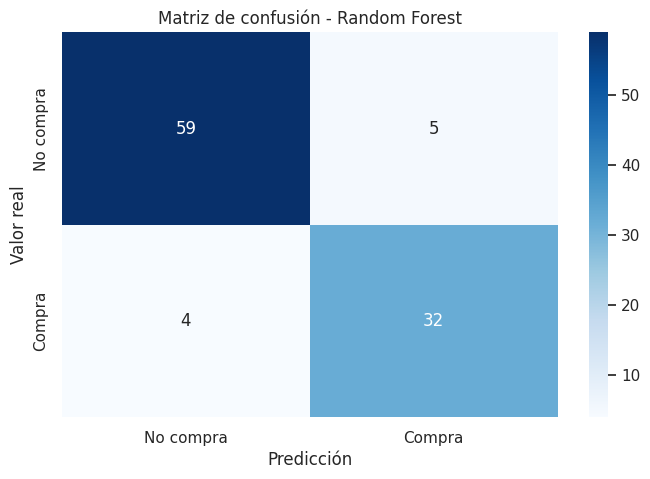

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        64
           1       0.86      0.89      0.88        36

    accuracy                           0.91       100
   macro avg       0.90      0.91      0.90       100
weighted avg       0.91      0.91      0.91       100



In [9]:
# ============================================
# 6: Evaluación del modelo
# ============================================

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predicciones sobre el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No compra", "Compra"],
            yticklabels=["No compra", "Compra"])
plt.title("Matriz de confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

### Análisis del desempeño del modelo Random Forest

El modelo Random Forest alcanzó un valor de *accuracy* de 0.91 sobre el conjunto de prueba, lo que indica un nivel elevado de aciertos globales en la clasificación de los usuarios según su decisión de compra.

La matriz de confusión muestra que el modelo clasificó correctamente 59 de los 64 casos correspondientes a la clase “No compra” y 32 de los 36 casos de la clase “Compra”. Se identifican 5 falsos positivos (usuarios clasificados como compradores que en realidad no compraron) y 4 falsos negativos (usuarios que compraron pero fueron clasificados como no compradores). Esta distribución de errores sugiere un comportamiento equilibrado entre ambas clases.

El reporte de clasificación confirma este comportamiento. Para la clase “No compra”, el modelo presenta valores altos de *precision* (0.94) y *recall* (0.92), mientras que para la clase “Compra” se obtienen valores de *precision* de 0.86 y *recall* de 0.89. El *F1-score* se mantiene elevado en ambas clases, con valores de 0.93 y 0.88 respectivamente.

En conjunto, estos resultados indican que el modelo presenta un buen desempeño predictivo y un equilibrio razonable entre confirmación de compradores reales y control de errores, lo que lo convierte en una base adecuada para aplicar técnicas de explicabilidad y analizar cómo las variables influyen en sus decisiones.

<class 'numpy.ndarray'>
(100, 3, 2)


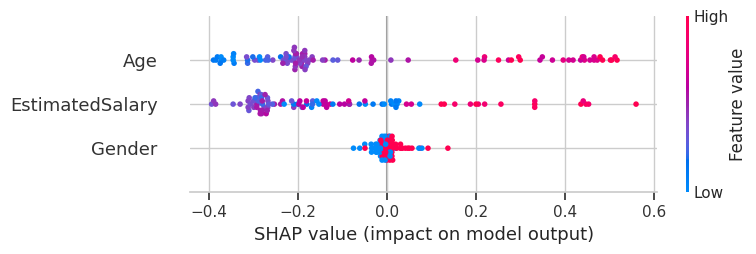

In [16]:
# ============================================
# 7: SHAP - Explicabilidad global
# ============================================

# Crear explicador
explainer = shap.TreeExplainer(rf_model)

# Calcular valores SHAP
shap_values = explainer.shap_values(X_test)

# Verificar forma de shap_values
print(type(shap_values))
print(np.array(shap_values).shape)

# Caso 1: shap_values es una lista (formato clásico)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]

# Caso 2: shap_values es un array 3D (formato nuevo)
else:
    shap_values_class1 = shap_values[:, :, 1]

# Summary plot (beeswarm) para la clase "Compra"
shap.summary_plot(
    shap_values_class1,
    X_test,
    feature_names=X.columns
)

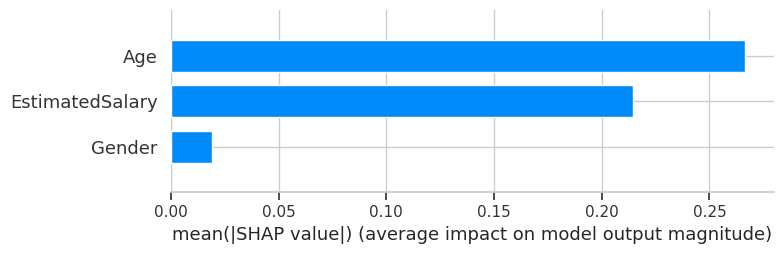

In [17]:
# ============================================
# 8: SHAP - Importancia global (bar plot)
# ============================================

shap.summary_plot(
    shap_values_class1,
    X_test,
    feature_names=X.columns,
    plot_type="bar"
)

### Explicabilidad global del modelo mediante SHAP

El gráfico *summary plot* de SHAP muestra que la variable **Age** es la que ejerce mayor influencia en las predicciones del modelo Random Forest, seguida por **EstimatedSalary**, mientras que **Gender** presenta un impacto considerablemente menor. Esta jerarquía se confirma en el gráfico de barras de importancia global, donde el valor medio absoluto de SHAP es claramente superior para *Age* y *EstimatedSalary* en comparación con *Gender*.

En el caso de **Age**, los valores más altos de la variable se asocian principalmente con valores SHAP positivos, lo que indica que edades mayores incrementan la probabilidad de que el modelo prediga la clase *Compra*. Por el contrario, valores bajos de edad tienden a contribuir negativamente a dicha predicción. Este comportamiento sugiere que la edad es un factor determinante en la decisión del modelo.

Para **EstimatedSalary**, se observa un patrón similar: salarios más altos tienden a empujar la predicción hacia la clase *Compra*, mientras que salarios más bajos contribuyen a predicciones de *No compra*. La dispersión observada indica que esta variable tiene un efecto relevante, aunque con mayor variabilidad en su impacto en comparación con la edad.

La variable **Gender**, codificada de forma binaria, muestra valores SHAP concentrados alrededor de cero, lo que indica que su contribución al resultado del modelo es limitada. Aunque el modelo utiliza esta variable, su peso relativo es significativamente menor frente a las variables continuas, lo que reduce el riesgo de que el género sea el principal determinante de las decisiones predictivas.

En conjunto, el análisis global con SHAP evidencia que el modelo basa principalmente sus decisiones en variables socioeconómicas cuantitativas, lo que favorece la transparencia del sistema y permite identificar de manera clara qué factores influyen en las predicciones.

In [18]:
# ============================================
# 9: Selección de 2 casos individuales
# ============================================

# Creamos un DataFrame para revisar predicciones y valores reales
results_df = X_test.copy()
results_df["y_true"] = y_test.values
results_df["y_pred"] = y_pred

# Casos correctamente clasificados por clase real
correct_buyers = results_df[(results_df["y_true"] == 1) & (results_df["y_pred"] == 1)]
correct_nonbuyers = results_df[(results_df["y_true"] == 0) & (results_df["y_pred"] == 0)]

print("Casos correctos (Compra=1):", correct_buyers.shape[0])
print("Casos correctos (No compra=0):", correct_nonbuyers.shape[0])

# Elegimos un ejemplo de cada grupo (primer registro)
idx_buy = correct_buyers.index[0]
idx_no = correct_nonbuyers.index[0]

print("\nÍndice ejemplo Compra (1):", idx_buy)
print("Índice ejemplo No compra (0):", idx_no)

# Mostrar las características de ambos casos
display(results_df.loc[[idx_buy, idx_no], X.columns])

Casos correctos (Compra=1): 32
Casos correctos (No compra=0): 59

Índice ejemplo Compra (1): 265
Índice ejemplo No compra (0): 349


,Gender,Age,EstimatedSalary
265,0,42,108000
349,1,38,61000


SHAP local - Caso predicho como COMPRA (1)


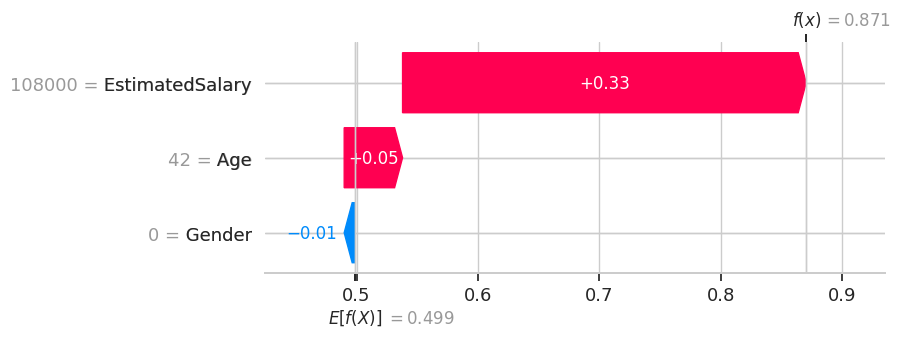


SHAP local - Caso predicho como NO COMPRA (0)


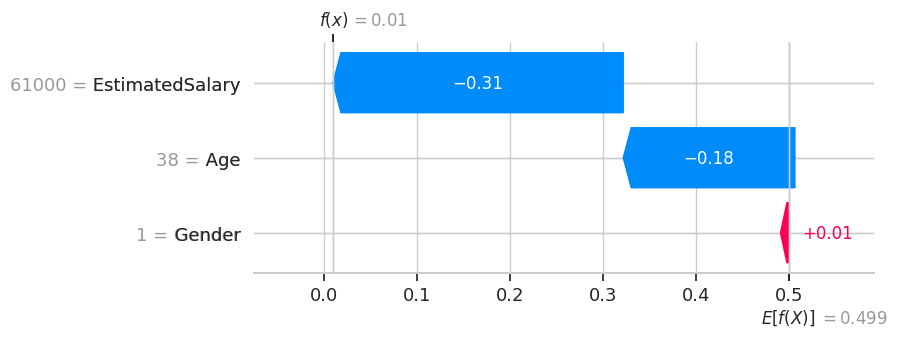

In [19]:
# ============================================
# 10: SHAP local (waterfall) para 2 casos
# ============================================

# Usamos la versión moderna con Explanation para waterfall plots
# base_values y shap_values deben corresponder a la clase 1 (Compra)

# 1) Obtener valores base (expected value) para la clase 1
# - Si es lista: expected_value[1]
# - Si no: expected_value puede ser array; tomamos el componente de clase 1 si aplica
expected_value = explainer.expected_value
if isinstance(expected_value, (list, tuple, np.ndarray)) and np.ndim(expected_value) > 0:
    base_value_class1 = expected_value[1]
else:
    base_value_class1 = expected_value

# 2) Construir explicaciones para ambos casos
def make_explanation(index_id):
    x_row = X_test.loc[index_id]
    # shap_values_class1 ya lo calculaste en las celdas globales
    sv_row = shap_values_class1[list(X_test.index).index(index_id)]
    return shap.Explanation(
        values=sv_row,
        base_values=base_value_class1,
        data=x_row.values,
        feature_names=X.columns
    )

exp_buy = make_explanation(idx_buy)
exp_no = make_explanation(idx_no)

# 3) Waterfall plots
print("SHAP local - Caso predicho como COMPRA (1)")
shap.plots.waterfall(exp_buy, max_display=10)

print("\nSHAP local - Caso predicho como NO COMPRA (0)")
shap.plots.waterfall(exp_no, max_display=10)

### Explicabilidad local del modelo mediante SHAP

Para analizar el comportamiento del modelo a nivel individual, se seleccionaron dos observaciones correctamente clasificadas: un caso correspondiente a la clase *Compra* y otro a la clase *No compra*. Esta selección permite contrastar cómo las variables influyen de manera diferente en decisiones opuestas del modelo.

En el caso clasificado como *Compra* (índice 265), el modelo asigna una probabilidad elevada a la clase positiva. El gráfico SHAP local muestra que el **ingreso estimado** es el principal factor que impulsa la predicción hacia la compra, con una contribución positiva dominante. La **edad** también contribuye positivamente, aunque con un impacto menor, mientras que la variable **Gender** presenta una influencia prácticamente nula. En conjunto, estas contribuciones desplazan el valor base del modelo hacia una probabilidad alta de compra.

En contraste, el caso clasificado como *No compra* (índice 349) presenta una probabilidad muy baja de compra. En este escenario, tanto el **ingreso estimado** como la **edad** aportan contribuciones negativas relevantes, empujando la predicción hacia la clase *No compra*. La variable **Gender**, nuevamente, muestra un efecto marginal y no determinante en la decisión final del modelo.

Este análisis local evidencia que el modelo basa sus decisiones principalmente en variables cuantitativas relacionadas con el perfil socioeconómico del usuario, mientras que el género no actúa como un factor decisivo. La coherencia entre los análisis global y local refuerza la transparencia del modelo y permite comprender de forma clara cómo se construyen predicciones individuales.

In [27]:
# ============================================
# 11: LIME - Crear el explicador tabular
# ============================================

# Datos de entrenamiento como numpy (LIME trabaja mejor con arrays)
X_train_np = X_train.values
X_test_np = X_test.values

# Nombres de variables
feature_names = list(X.columns)

# Nombres de clases (0: No compra, 1: Compra)
class_names = ["No compra", "Compra"]

# Índices de características categóricas: Gender (0/1)
categorical_features = [feature_names.index("Gender")]

explainer_lime = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    categorical_features=categorical_features,
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Explicación LIME - Caso COMPRA (idx=265)


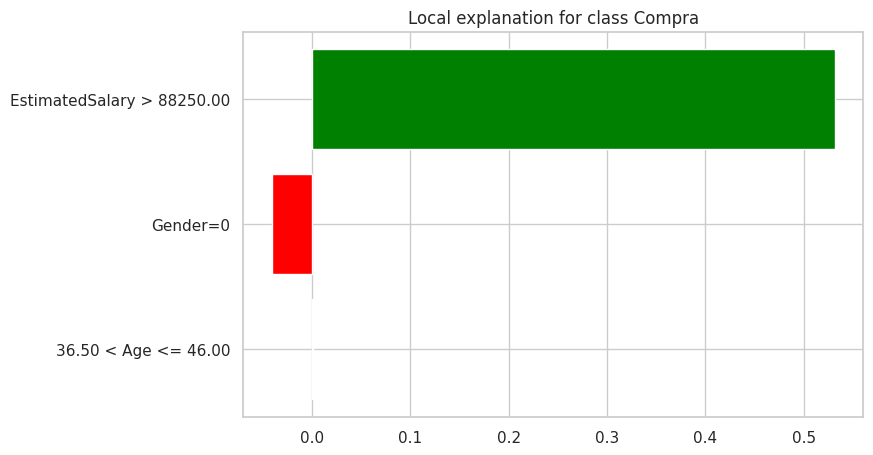

Explicación LIME - Caso NO COMPRA (idx=349)


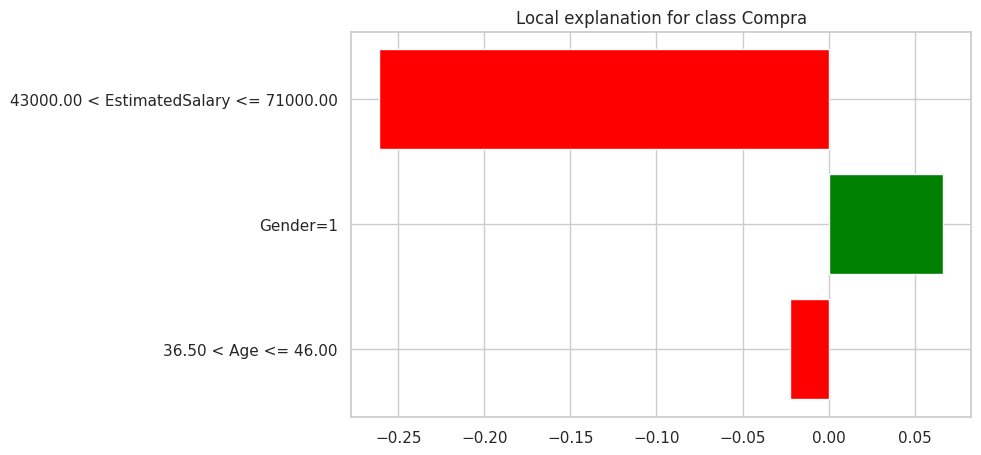

In [28]:
# ============================================
# 12: LIME - Explicaciones locales (2 casos)
# ============================================

# Función de predicción de probabilidad requerida por LIME
predict_proba_fn = rf_model.predict_proba

# Obtener la posición (fila) de cada índice dentro de X_test
test_index_list = list(X_test.index)
row_buy = test_index_list.index(idx_buy)
row_no = test_index_list.index(idx_no)

# Caso Compra (idx_buy)
exp_lime_buy = explainer_lime.explain_instance(
    data_row=X_test_np[row_buy],
    predict_fn=predict_proba_fn,
    num_features=10,
    num_samples=1000
)

# Caso No compra (idx_no)
exp_lime_no = explainer_lime.explain_instance(
    data_row=X_test_np[row_no],
    predict_fn=predict_proba_fn,
    num_features=10,
    num_samples=1000
)

print(f"Explicación LIME - Caso COMPRA (idx={idx_buy})")
fig1 = exp_lime_buy.as_pyplot_figure()
plt.show()

print(f"Explicación LIME - Caso NO COMPRA (idx={idx_no})")
fig2 = exp_lime_no.as_pyplot_figure()
plt.show()

### Explicabilidad local del modelo mediante LIME

Las explicaciones generadas con LIME permiten analizar cómo el modelo Random Forest toma decisiones a nivel individual, aproximando su comportamiento mediante un modelo interpretable local.

En el caso clasificado como *Compra* (índice 265), LIME identifica al **ingreso estimado** como el principal factor que impulsa la predicción hacia la clase positiva, particularmente al situarse por encima de un umbral elevado. La variable **Age** presenta una contribución menor y positiva, mientras que **Gender** muestra un impacto reducido y cercano a cero. Esta explicación es consistente con los resultados obtenidos mediante SHAP, donde el ingreso y la edad fueron las variables más influyentes.

En el caso clasificado como *No compra* (índice 349), LIME muestra que un **ingreso estimado en un rango medio-bajo** contribuye de forma significativa a reducir la probabilidad de compra. La **edad** también aporta una contribución negativa, mientras que el **género** tiene un efecto limitado y no determinante en la decisión final. Nuevamente, el patrón observado coincide con el análisis local realizado mediante SHAP.

En conjunto, las explicaciones locales obtenidas con LIME refuerzan la interpretación de que el modelo basa sus decisiones principalmente en variables cuantitativas relacionadas con el perfil socioeconómico del usuario, mientras que el género no actúa como un factor dominante en la clasificación.

### Comparación entre SHAP y LIME

Tanto SHAP como LIME permiten explicar las decisiones del modelo a nivel local, aunque desde enfoques conceptuales diferentes. SHAP se basa en valores de Shapley provenientes de la teoría de juegos, proporcionando explicaciones consistentes tanto a nivel global como local. En contraste, LIME construye un modelo interpretable local que aproxima el comportamiento del modelo complejo en el entorno de una observación específica.

En este estudio, ambas técnicas coinciden en identificar a **Age** y **EstimatedSalary** como las variables más influyentes en las predicciones individuales, mientras que **Gender** presenta un impacto reducido. Esta concordancia entre métodos incrementa la confianza en la interpretación del modelo y refuerza la transparencia de sus decisiones.

Una diferencia relevante es que SHAP permite visualizar directamente la contribución exacta de cada variable al desplazamiento desde un valor base hacia la predicción final, mientras que LIME expresa las explicaciones en términos de reglas locales y rangos de valores. En conjunto, el uso combinado de ambas técnicas ofrece una comprensión más completa y robusta del proceso de decisión del modelo.

## **Reflexión final**

**Transparencia del modelo**  
El uso de técnicas de explicabilidad como SHAP y LIME permitió comprender de manera clara cómo el modelo Random Forest toma sus decisiones. Los análisis globales y locales evidencian que las predicciones se fundamentan principalmente en variables cuantitativas como la edad y el ingreso estimado, lo que reduce el carácter de “caja negra” del modelo y facilita su interpretación tanto a nivel agregado como individual.

**Riesgos éticos y sociales si se implementa el sistema**  
La implementación de un modelo predictivo basado en variables socioeconómicas puede implicar riesgos éticos y sociales, especialmente si se utiliza para tomar decisiones que afecten a las personas. Variables como la edad o el ingreso podrían contribuir a la exclusión de ciertos grupos si no se gestionan adecuadamente. No obstante, el análisis mostró que la variable *Gender* tiene un impacto reducido, lo que disminuye el riesgo de sesgos directos asociados a esta característica sensible.

**Consideraciones para mejorar el modelo**  
Para mejorar el modelo, sería recomendable evaluar su desempeño con nuevos conjuntos de datos y analizar su estabilidad en diferentes contextos. Asimismo, podrían incorporarse mecanismos de monitoreo continuo que permitan detectar cambios en la importancia de las variables y posibles sesgos emergentes. La validación periódica del modelo contribuiría a mantener su confiabilidad y equidad.

**¿Qué aprendizaje desarrolló sobre cómo el modelo toma decisiones?**  
El principal aprendizaje obtenido es que el modelo combina las variables disponibles de forma no lineal, asignando mayor peso a aquellas que aportan mayor capacidad discriminativa. La edad y el ingreso estimado influyen de manera significativa en las predicciones, mientras que el género tiene un rol secundario. Este análisis permitió comprender que el buen desempeño predictivo debe ir acompañado de una comprensión clara del proceso de decisión.

**¿Hay alguna variable que tenga un peso excesivo?**  
A partir de los resultados de SHAP, se observa que la edad es la variable con mayor peso relativo en el modelo, seguida del ingreso estimado. Sin embargo, no se identifica una dominancia extrema de una sola variable, ya que las decisiones del modelo se apoyan en la combinación de varios factores, lo que sugiere un comportamiento relativamente equilibrado.

**¿Qué pasaría si este modelo se implementa sin explicabilidad?**  
Si el modelo se implementara sin técnicas de explicabilidad, resultaría difícil justificar las decisiones individuales ante usuarios o entidades reguladoras. Esto podría afectar la confianza en el sistema y aumentar los riesgos éticos y legales. La ausencia de explicabilidad limitaría la detección de sesgos y errores, mientras que su incorporación permite un uso más transparente, responsable y alineado con principios éticos en sistemas predictivos.